In [1]:
import sys
from pathlib import Path
sys.path.append('../')
import pandas as pd
from kkexpr.core import Factor
from kkexpr.data.loader import CSVDataloader
from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]

In [2]:
data_path = Path('../kkexpr/data/quotes')
loader = CSVDataloader(
    path=data_path,
    symbols=['GOLD','^NDX'],
    start_date='20230101',
    end_date='20240331'
)

# Load base data and convert to numeric
df = loader.load()
for col in ['open', 'high', 'low', 'close', 'volume']:
    df[col] = pd.to_numeric(df[col])

print("\n1. Data Sample:")
print(df.head())



2024-12-02 19:25:03.591 | DEBUG    | kkexpr.data.loader:__init__:29 - Initialized CSVDataloader with path=..\kkexpr\data\quotes, symbols=['GOLD', '^NDX'], start_date=20230101, end_date=20240331
2024-12-02 19:25:03.592 | DEBUG    | kkexpr.data.loader:load:35 - Loading data with fields=None, names=None
2024-12-02 19:25:03.592 | DEBUG    | kkexpr.data.loader:load:40 - Reading file: ..\kkexpr\data\quotes\GOLD.csv
2024-12-02 19:25:03.633 | DEBUG    | kkexpr.data.loader:load:50 - Loaded GOLD data shape: (9915, 6)
2024-12-02 19:25:03.634 | DEBUG    | kkexpr.data.loader:load:40 - Reading file: ..\kkexpr\data\quotes\^NDX.csv
2024-12-02 19:25:03.671 | DEBUG    | kkexpr.data.loader:load:50 - Loaded ^NDX data shape: (9757, 6)
2024-12-02 19:25:03.673 | DEBUG    | kkexpr.data.loader:load:54 - Concatenated DataFrame shape: (19672, 6)
2024-12-02 19:25:03.684 | DEBUG    | kkexpr.data.loader:load:61 - Index sorted
2024-12-02 19:25:03.685 | DEBUG    | kkexpr.data.loader:load:66 - Date range: 2023-01-01 0


1. Data Sample:
                        open       high        low      close    volume
symbol date                                                            
GOLD   2023-01-03  16.905594  17.300765  16.818849  17.185104  16347400
       2023-01-04  17.493530  18.370616  17.454978  18.197126  29096000
       2023-01-05  17.965807  18.148935  17.676658  18.100744  17933600
       2023-01-06  18.409171  18.476638  17.850149  18.351341  21704000
       2023-01-09  18.524828  18.669405  18.274232  18.283871  18346700


In [3]:
# Calculate returns
df['returns'] = df['close'].groupby(level='symbol').shift(1)
df['returns'] = df['close'] / df['returns'] - 1

# Create WorldQuant101 Alpha1 factor
alpha1_expr = '((ts_rank(volume, 32) * (1 - ts_rank(((close + high) - low), 16))) * (1 - ts_rank(returns, 32)))'
print("\n2. Alpha1 Expression:")
print(alpha1_expr)

# Test each component separately
print("\n3. Testing Components:")

# Component 1: Volume rank
vol_rank = Factor("ts_rank(volume, 32)")
vol_result = vol_rank.execute(
    order_book_ids=['GOLD'],
    frequency='1d',
    start_date='20230101',
    end_date='20240331',
    test_data=df
)
print("\nVolume Rank (first 5 non-null):")
print(vol_result[vol_result.notna()].head())

# Component 2: Price spread rank
spread_rank = Factor("ts_rank(((close + high) - low), 16)")
spread_result = spread_rank.execute(
    order_book_ids=['GOLD'],
    frequency='1d',
    start_date='20230101',
    end_date='20240331',
    test_data=df
)
print("\nPrice Spread Rank (first 5 non-null):")
print(spread_result[spread_result.notna()].head())

# Component 3: Returns rank
ret_rank = Factor("ts_rank(returns, 32)")
ret_result = ret_rank.execute(
    order_book_ids=['GOLD'],
    frequency='1d',
    start_date='20230101',
    end_date='20240331',
    test_data=df
)
print("\nReturns Rank (first 5 non-null):")
print(ret_result[ret_result.notna()].head())


2024-12-02 19:25:24,549 - kkexpr.core.engine - ERROR - Failed to evaluate expression 'ts_rank(volume, 32)': name 'namespace' is not defined



2. Alpha1 Expression:
((ts_rank(volume, 32) * (1 - ts_rank(((close + high) - low), 16))) * (1 - ts_rank(returns, 32)))

3. Testing Components:


ValueError: Invalid expression: ts_rank(volume, 32)

In [10]:

# Full Alpha1 factor
alpha1_factor = Factor(alpha1_expr)
alpha1_result = alpha1_factor.execute(
    order_book_ids=['GOLD'],
    frequency='1d',
    start_date='20230101',
    end_date='20240331',
    test_data=df
)


In [15]:

print("\n4. Final Alpha1 Result:")
print("\nFirst 5 non-null values:")




4. Final Alpha1 Result:

First 5 non-null values:


symbol  date      
GOLD    2023-02-17    0.549316
        2023-02-21    0.201416
        2023-02-22    0.547485
        2023-02-23    0.181274
        2023-02-24    0.178528
                        ...   
        2024-03-22    0.324707
        2024-03-25    0.024719
        2024-03-26    0.123047
        2024-03-27    0.000000
        2024-03-28    0.000000
Name: ((ts_rank(volume, 32) * (1 - ts_rank(((close + high) - low), 16))) * (1 - ts_rank(returns, 32))), Length: 279, dtype: float64

<Axes: xlabel='symbol,date'>

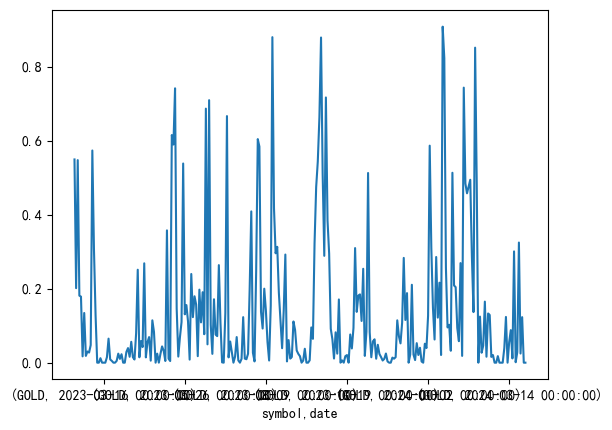

In [18]:
alpha1_result.plot()


In [12]:
print("\nBasic statistics:")
valid_results = alpha1_result[alpha1_result.notna()]
print(valid_results.describe())


Basic statistics:
count    279.000000
mean       0.143259
std        0.198175
min        0.000000
25%        0.014587
50%        0.058594
75%        0.181274
max        0.908203
Name: ((ts_rank(volume, 32) * (1 - ts_rank(((close + high) - low), 16))) * (1 - ts_rank(returns, 32))), dtype: float64
